In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# return first row of measurement table

measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2dd2bdd79e8>,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
# return first row of station table
station_first_row = session.query(Station).first()
station_first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2dd2be58588>,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [12]:
# sort date and get the latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# get the date for one year ago
one_year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago

# A query to retrieve the last 12 months of precipitation data
# And calculate the average if we have mutltiple data points on the same date
results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date >= one_year_ago).\
    group_by(Measurement.date).all()
results

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [13]:
# Save the query results as a Pandas DataFrame
prcp_data_df = pd.DataFrame(results, columns=['Date', 'Precipitation Data'])

# Set the index to the date column
prcp_data_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prcp_data_df = prcp_data_df.sort_index(ascending=True)

# return the first 5 rows of the dataframe
prcp_data_df.head()

,Precipitation Data
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


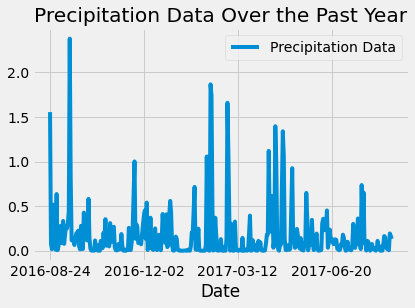

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot(title="Precipitation Data Over the Past Year")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,Precipitation Data
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [16]:
# Design a query to show how many stations are available in this dataset?
numberOfStations = session.query(Station.id).count()
print(f"There are {numberOfStations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationsCount = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stationsCount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mostActiveStation = stationsCount[0][0]

tempQuery = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == mostActiveStation).all()
tempQuery

print(f"The lowest temperature of the most active station - ({mostActiveStation}) is {tempQuery[0][0]}.")
print(f"The average temperature of the most active station - ({mostActiveStation}) is {tempQuery[0][1]}.")
print(f"The highest temperature of the most active station - ({mostActiveStation}) is {tempQuery[0][2]}.")


The lowest temperature of the most active station - (USC00519281) is 54.0.
The average temperature of the most active station - (USC00519281) is 71.66378066378067.
The highest temperature of the most active station - (USC00519281) is 85.0.


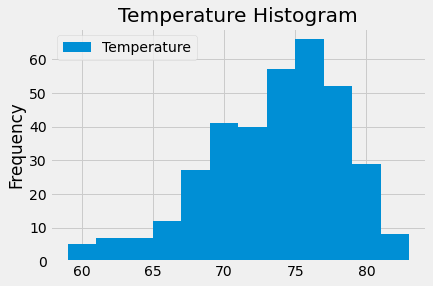

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
tempResult = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == mostActiveStation).\
    group_by(Measurement.date).all()

# convert the query result into dataframe
temp_df= pd.DataFrame(tempResult, columns=['Date', 'Temperature'])

# Set the index to the date column
temp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
temp_df.sort_index(ascending=True)

# Plot the results as a histogram
temp_df.plot(kind='hist', bins=12 , title='Temperature Histogram')

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
MyTrip = '2021-08-08 to 2021-08-15'
tripStartDate = '2017-08-08'
tripEndDate = '2017-08-15'

#calculate the tmin, tavg, and tmax 
tripTemp = calc_temps(tripStartDate, tripEndDate)

tripTemp

[(70.0, 78.54545454545455, 84.0)]

Text(0, 0.5, 'Temperature')

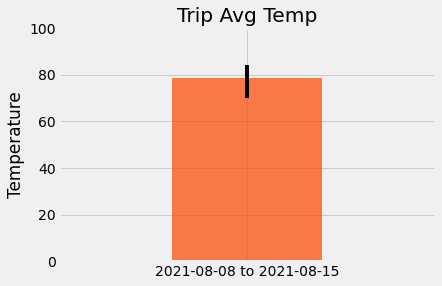

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTemp = tripTemp[0][0]
avgTemp = tripTemp[0][1]
maxTemp = tripTemp[0][2]

minError = avgTemp - minTemp
maxError = maxTemp - avgTemp
errorBars = np.array([[minError], [maxError]])

plt.title('Trip Avg Temp')
plt.bar(MyTrip, avgTemp, yerr=errorBars, color = 'orangered', alpha = .7)
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature')

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

rainfallResult = (session.query(*sel).\
                  filter(Station.station == Measurement.station).\
                  filter(Measurement.date >= tripStartDate).\
                  filter(Measurement.date <= tripEndDate).\
                  group_by(Station.station).\
                  order_by(func.sum(Measurement.prcp).desc()).all())

rainfallResult

rainfall_df = pd.DataFrame(rainfallResult,  columns=['Station', 'Location', 'Precipitation', 'Latitude', 'Longitude', 'Elevation'])
rainfall_df


,Station,Location,Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.34,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.32,21.45167,-157.84889,32.9
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.14,21.33556,-157.71139,19.5
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.11,21.52130,-157.83740,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.27160,-157.81680,3.0


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
tripStartDate = "2017-08-08"
tripEndDate = "2017-08-15"
tripLength = int(tripEndDate[-2:]) - int(tripStartDate[-2:]) + 1

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
startDate = dt.datetime.strptime(tripStartDate, '%Y-%m-%d')

dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') for x in range(0, tripLength)]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in dateList]
normals

[[(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0)],
 [(71.0, 76.98245614035088, 84.0)],
 [(71.0, 76.77777777777777, 82.0)],
 [(69.0, 76.47169811320755, 83.0)]]

In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normalList = [np.array(normal[0]) for normal in normals]
normals_df = pd.DataFrame(normalList, columns=['Lowest Temperature', 'Average Temperature', 'Highest Temperature'])
normals_df['Date'] = dateList
normals_df.set_index('Date', inplace=True)
normals_df.sort_index(ascending=True)
normals_df

,Lowest Temperature,Average Temperature,Highest Temperature
Date,,,
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0


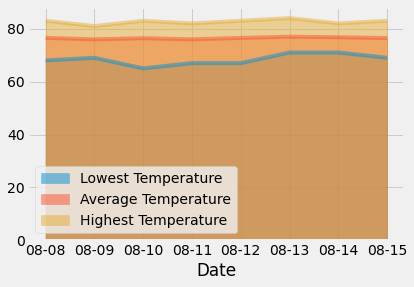

In [50]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)